# Model Training
This file trains the model specified in the variable `MODEL` and produces the metrics and graphs detailed in the folders ending in _Info.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# To run only on CPU:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

MODEL = "MobileNet" # InceptionV3, Xception, ResNet50, or MobileNet
HARD = False # Whether or not to train on Dataset or Dataset-Hard
training_split = 0.2 # How to split the data; ex. 0.2 means 80% training, 20% validation
PRETRAINED = True

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

print("Successfully imported libraries.")

Successfully imported libraries.


Getting Data

In [2]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# Get this dataset
data_dir = pathlib.Path(F"./Dataset{'-Hard' if HARD else ''}") # -Hard

image_count = len(list(data_dir.glob("*/*.jp*g")))
print("Images available to use: " + str(image_count))

GPUs Available:  []
Images available to use: 14682


In [3]:
# Put into an image dataset.

batch_size = 64
img_height = 224
img_width = 224
channels = 3
# By default, no preprocessing
preprocess = None

if MODEL in ("InceptionV3", "Xception"):
    # Image size should be (299, 299)
    img_height = 299
    img_width = 299

if MODEL == "CustomModel":
    img_height = 400
    img_width = 400
    batch_size = 32

if MODEL == "InceptionV3":
    # Use different preprocessing function
    preprocess = tf.keras.applications.inception_v3.preprocess_input
elif MODEL == "Xception":
    # Use different preprocessing function
    preprocess = tf.keras.applications.xception.preprocess_input
elif MODEL == "MobileNet":
    preprocess = tf.keras.applications.mobilenet.preprocess_input
elif MODEL == "ResNet50":
    preprocess = tf.keras.applications.resnet50.preprocess_input
elif MODEL == "EfficientNetB3":
    preprocess = tf.keras.applications.efficientnet.preprocess_input

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=training_split,
    subset="training",
    color_mode=("grayscale" if channels == 1 else "rgb"),
    seed=314,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=training_split,
    subset="validation",
    seed=314,
    color_mode=("grayscale" if channels == 1 else "rgb"),
    image_size=(img_height,img_width),
    batch_size=batch_size
)

# Apply preprocessing:
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

if preprocess:
    print("Applying preprocessing...")
    train_ds = train_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)

print(F"Using classes: {', '.join(class_names)}")
print(F"Image shape: ({img_width}, {img_height}, {channels})")

Found 14699 files belonging to 2 classes.
Using 11760 files for training.
Found 14699 files belonging to 2 classes.
Using 2939 files for validation.
Applying preprocessing...
Using classes: Guns, No Guns
Image shape: (224, 224, 3)


Visualizing Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

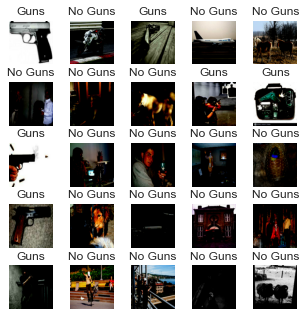

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(5, 5))

for images, labels in train_ds.take(1):
    for i in range(25):
        ax = fig.add_subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy()) # .astype("uint8")
        ax.set_title(class_names[labels[i]], fontsize=12)
        plt.axis("off")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.savefig(F"{MODEL}_Info/sample_img_{MODEL}.jpg")
plt.show()

Performance Tuning

In [5]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the Model!

In [6]:
num_classes = len(class_names)

map_model = {
    "InceptionV3": tf.keras.applications.InceptionV3,
    "VGG16": tf.keras.applications.VGG16,
    "VGG19": tf.keras.applications.VGG19,
    "Xception": tf.keras.applications.Xception,
    "MobileNetV3Large": tf.keras.applications.MobileNetV3Large,
    "MobileNet": tf.keras.applications.MobileNet,
    "ResNet50": tf.keras.applications.ResNet50,
    "EfficientNetB3": tf.keras.applications.EfficientNetB3,
    "CustomModel": Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])
}

if not MODEL == "CustomModel": 
    base_model = map_model[MODEL](input_shape=(img_width, img_height, channels), include_top=not PRETRAINED, weights='imagenet' if PRETRAINED else None)

    if not PRETRAINED:
        model = base_model
    else:
        inputs = tf.keras.Input(shape=(img_width, img_height, channels))
        base_model.trainable = True
        base_model_1 = base_model(inputs, training=True)

        # 2) Add classification head
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_1)
        dropout = tf.keras.layers.Dropout(0.2)(global_average_layer)
        outputs = tf.keras.layers.Dense(num_classes)(dropout)

        model = tf.keras.Model(inputs, outputs)
else:
    model = map_model[MODEL]

tf.keras.utils.plot_model(
    model, to_file=F"{MODEL}_Info/{MODEL}{'_Pretrained' if PRETRAINED else ''}-Structure-Concat.png")
fh = open(F"{MODEL}_Info/{MODEL}{'_Pretrained' if PRETRAINED else ''}-Summary.txt", "w")
model.summary(print_fn=lambda x: fh.write(x + '\n'))

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 3,230,914
Trainable params: 3,209,026
Non-train

In [7]:
# Compile model
print(len(model.trainable_variables))
base_learning_rate = 5e-2
model.compile(optimizer=tf.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", "mse"])

# Save model here every 100 batches
checkpoint_path = F"{MODEL}_weights{'_Pretrained' if PRETRAINED else ''}/{MODEL}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor="val_accuracy",
                                                 model="max",
                                                 save_freq='epoch',
                                                 save_best_only=True)


# Get last model saved
# model.load_weights(checkpoint_path)
print(F"Restored weights from {checkpoint_path}")

83
Restored weights from MobileNet_weights_Pretrained/MobileNet.ckpt


In [8]:
print(F"Layers in base model: {len(base_model.layers)}")

Layers in base model: 86


In [9]:
# Start training!
import csv
import tensorflow.keras.backend as K

# On end of batch, save model history into .csv; allows us to train multiple times over while retaining and being able to graph history.
class StoreModelHistory(keras.callbacks.Callback):
  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    # if not (F'{MODEL}_Info/model_history_{MODEL}.csv' in os.listdir("./")):
    #   with open(F'{MODEL}_Info/model_history_{MODEL}.csv','w') as f:
    #     y=csv.DictWriter(f,logs.keys())
    #     y.writeheader()

    with open(F'./{MODEL}_Info/model_history_{MODEL}.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)

# If pretraining, train once with a frozen base_model, then unfreeze base_model and set the bottom layers to be untrainable.
if PRETRAINED:
  epochs=10
else:
  epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp_callback, StoreModelHistory()]
)

history_fine = None

if PRETRAINED:
  # Time to retrain again with unfrozen base_model
  print(F"Pretrain successful, training again with unfrozen base model...")
  base_model.trainable = True

  model.summary()

  # Retrain with smaller learning rate
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
  
  total_epochs = epochs + 20 # Adding 20 epochs
  history_fine = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=total_epochs,
      initial_epoch = history.epoch[-1],
      callbacks=[cp_callback, StoreModelHistory()]
  )

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.6271 - mse: 20382.4023
Epoch 00001: val_accuracy improved from -inf to 0.63695, saving model to MobileNet_weights_Pretrained\MobileNet.ckpt
184/184 [==============================] - 494s 3s/step - loss: 0.7159 - accuracy: 0.6271 - mse: 20382.4023 - val_loss: 0.6931 - val_accuracy: 0.6370 - val_mse: 22369.2188 - lr: 0.0500
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.6288 - mse: 22418.3379
Epoch 00002: val_accuracy did not improve from 0.63695
184/184 [==============================] - 499s 3s/step - loss: 0.6931 - accuracy: 0.6288 - mse: 22418.3379 - val_loss: 0.6931 - val_accuracy: 0.6370 - val_mse: 22369.2188 - lr: 0.0500
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.6288 - mse: 22420.1406
Epoch 00003: val_accuracy did not improve from 0.63695
184/184 [==============================] - 505s 3s/step - los

In [35]:
model.load_weights(checkpoint_path)

Analyze Results

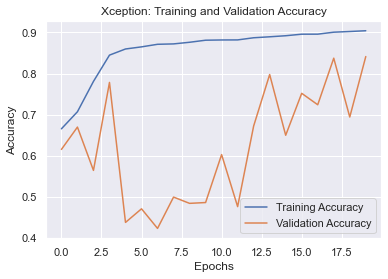

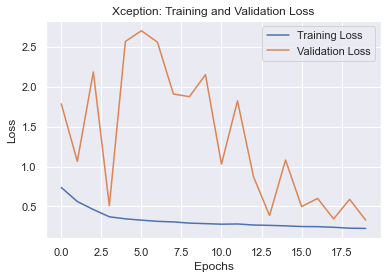

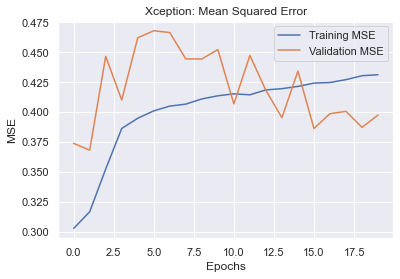

In [36]:
# Read file containing info

# loss,accuracy,mse,val_loss,val_accuracy,val_mse,lr
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

mse = history.history["mse"]
val_mse = history.history["val_mse"]

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(F'{MODEL}{" - Hard Dataset" if HARD else ""}: Training and Validation Accuracy')
plt.savefig(F"{MODEL}_Info/{MODEL}{'_Hard' if HARD else ''}_accuracy.png")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(F'{MODEL}{" - Hard Dataset" if HARD else ""}: Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(F"{MODEL}_Info/{MODEL}_loss.png")
plt.show()

plt.plot(epochs_range, mse, label='Training MSE')
plt.plot(epochs_range, val_mse, label='Validation MSE')
plt.legend(loc='upper right')
plt.title(F'{MODEL}{" - Hard Dataset" if HARD else ""}: Mean Squared Error')
plt.savefig(F"{MODEL}_Info/{MODEL}_MSE.png")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

In [37]:
import sklearn.metrics as metrics
import seaborn as sns
sns.set_theme()

def print_results(y_test, y_pred):
    # Show the test data's result
    print("Set results:")
    print("------------------------------------------------")
    # y_test = y_test.argmax(axis=1)
    # y_pred = y_pred.argmax(axis=1)
    print(metrics.confusion_matrix(y_test, y_pred))
    print('kappa:       ', metrics.cohen_kappa_score(y_test, y_pred))
    print('accuracy:    ', metrics.accuracy_score(y_test, y_pred))
    print('recall:      ', metrics.recall_score(y_test, y_pred, average=None))
    print('precision:   ', metrics.precision_score(y_test, y_pred, average=None))
    print('f_1:         ', metrics.f1_score(y_test, y_pred, average=None))


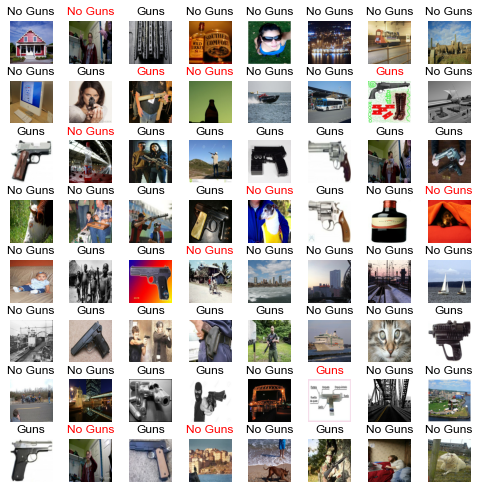

Set results:
------------------------------------------------
[[24  3]
 [ 8 29]]
kappa:        0.65625
accuracy:     0.828125
recall:       [0.88888889 0.78378378]
precision:    [0.75    0.90625]
f_1:          [0.81355932 0.84057971]


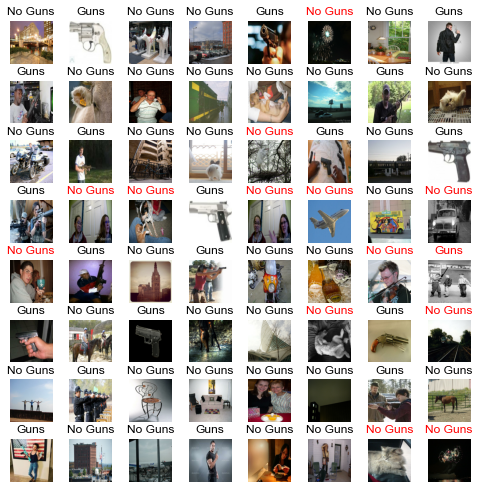

Set results:
------------------------------------------------
[[19  1]
 [13 31]]
kappa:        0.5625
accuracy:     0.78125
recall:       [0.95       0.70454545]
precision:    [0.59375 0.96875]
f_1:          [0.73076923 0.81578947]


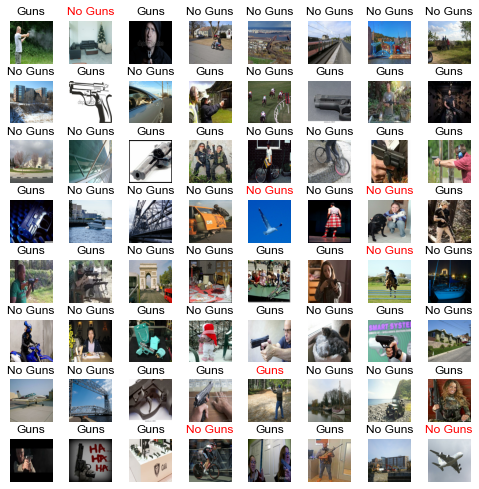

Set results:
------------------------------------------------
[[28  1]
 [ 6 29]]
kappa:        0.7825242718446602
accuracy:     0.890625
recall:       [0.96551724 0.82857143]
precision:    [0.82352941 0.96666667]
f_1:          [0.88888889 0.89230769]


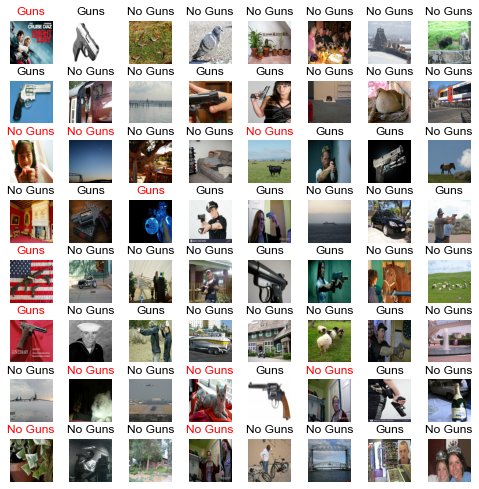

Set results:
------------------------------------------------
[[17  4]
 [ 8 35]]
kappa:        0.5945089757127772
accuracy:     0.8125
recall:       [0.80952381 0.81395349]
precision:    [0.68      0.8974359]
f_1:          [0.73913043 0.85365854]


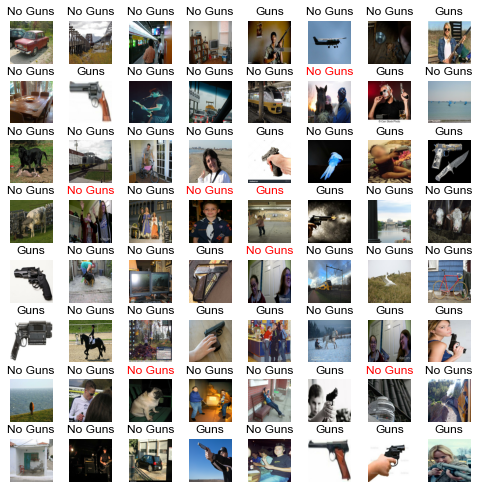

Set results:
------------------------------------------------
[[20  1]
 [ 6 37]]
kappa:        0.7661795407098121
accuracy:     0.890625
recall:       [0.95238095 0.86046512]
precision:    [0.76923077 0.97368421]
f_1:          [0.85106383 0.91358025]


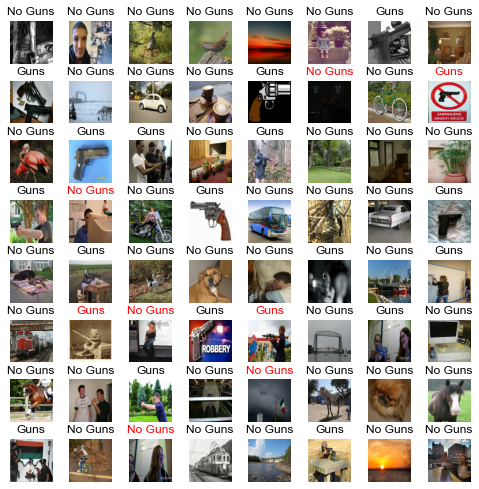

Set results:
------------------------------------------------
[[17  3]
 [ 5 39]]
kappa:        0.7168141592920354
accuracy:     0.875
recall:       [0.85       0.88636364]
precision:    [0.77272727 0.92857143]
f_1:          [0.80952381 0.90697674]


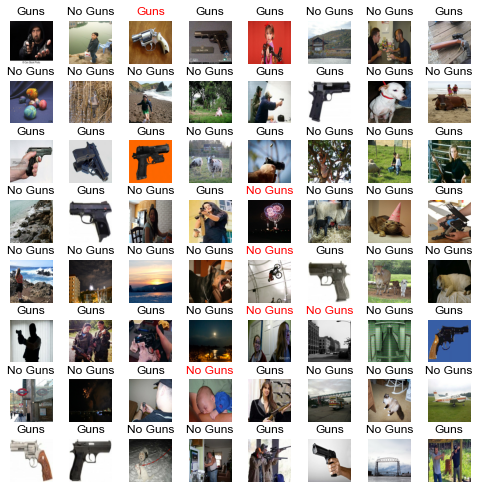

Set results:
------------------------------------------------
[[26  1]
 [ 5 32]]
kappa:        0.8115799803729147
accuracy:     0.90625
recall:       [0.96296296 0.86486486]
precision:    [0.83870968 0.96969697]
f_1:          [0.89655172 0.91428571]


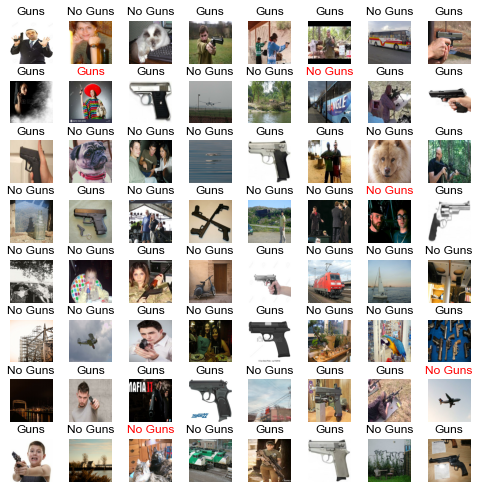

Set results:
------------------------------------------------
[[30  1]
 [ 4 29]]
kappa:        0.8440545808966862
accuracy:     0.921875
recall:       [0.96774194 0.87878788]
precision:    [0.88235294 0.96666667]
f_1:          [0.92307692 0.92063492]


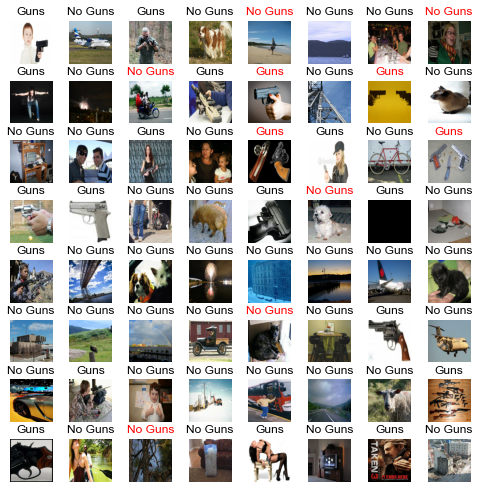

Set results:
------------------------------------------------
[[17  4]
 [ 6 37]]
kappa:        0.654054054054054
accuracy:     0.84375
recall:       [0.80952381 0.86046512]
precision:    [0.73913043 0.90243902]
f_1:          [0.77272727 0.88095238]


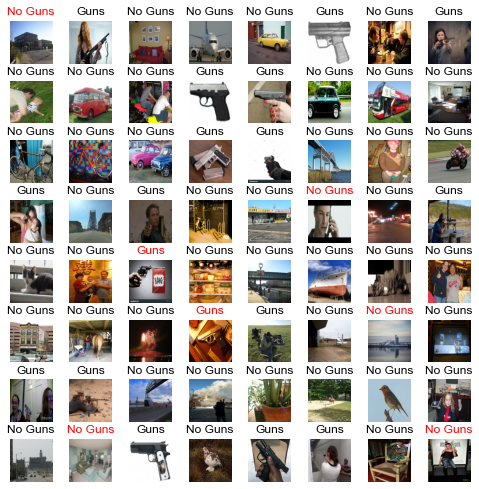

Set results:
------------------------------------------------
[[16  2]
 [ 5 41]]
kappa:        0.7425287356321839
accuracy:     0.890625
recall:       [0.88888889 0.89130435]
precision:    [0.76190476 0.95348837]
f_1:          [0.82051282 0.92134831]


In [38]:
# Product list of samples
from math import sqrt

for images, labels in val_ds.take(10):
    fig_calc = int(sqrt(len(images)))
    fig = plt.figure(figsize=(fig_calc, fig_calc))
    label_pred = model.predict(images)
    for i in range(fig_calc * fig_calc):
        ax = fig.add_subplot(fig_calc, fig_calc, i + 1)
        plt.imshow(((np.clip(images[i].numpy(), -1, 1) + 1)/2).astype(np.float32))
        ax.set_title(class_names[labels[i]], fontsize=12, color = "black" if labels[i] == np.argmax(label_pred[i]) else "red")
        plt.axis("off")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    print_results(labels, np.argmax(label_pred, axis=1))


Analyzing batch 0
Analyzing batch 1
Analyzing batch 2
Analyzing batch 3
Analyzing batch 4
Analyzing batch 5
Analyzing batch 6
Analyzing batch 7
Analyzing batch 8
Analyzing batch 9
Analyzing batch 10
Analyzing batch 11
Analyzing batch 12
Analyzing batch 13
Analyzing batch 14
Analyzing batch 15
Analyzing batch 16
Analyzing batch 17
Analyzing batch 18
Analyzing batch 19
Analyzing batch 20
Analyzing batch 21
Analyzing batch 22
Analyzing batch 23


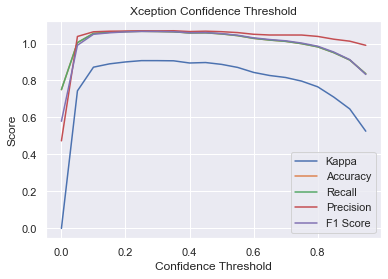

In [39]:
# For a batch, find the best confidence threshold.

x_points = np.arange(0, 1, 0.05)
y_point1 = np.zeros(len(x_points))
y_point2 = np.zeros(len(x_points))
y_point3 = np.zeros(len(x_points))
y_point4 = np.zeros(len(x_points))
y_point5 = np.zeros(len(x_points))
batch = 0
for images, labels in val_ds.take(300):
    print(F"Analyzing batch {batch}")
    label_pred = model.predict(images)
    x_point = 0
    for thresh in x_points:
        y_point1[x_point] += (metrics.cohen_kappa_score(labels, [i[1] > thresh for i in label_pred])) / len(x_points)
        y_point2[x_point] += (metrics.accuracy_score(labels, [i[1] > thresh for i in label_pred])) / len(x_points)
        y_point3[x_point] += (metrics.recall_score(labels, [i[1] > thresh for i in label_pred], average='weighted')) / len(x_points)
        y_point4[x_point] += (metrics.precision_score(labels, [i[1] > thresh for i in label_pred], average='weighted', zero_division=0)) / len(x_points)
        y_point5[x_point] += (metrics.f1_score(labels, [i[1] > thresh for i in label_pred], average='weighted')) / len(x_points)
        x_point += 1
    batch += 1

fig, ax = plt.subplots()
plot_1, = plt.plot(x_points, y_point1, label = "Kappa")
plot_2, = plt.plot(x_points, y_point2, label = "Accuracy")
plot_3, = plt.plot(x_points, y_point3, label = "Recall")
plot_4, = plt.plot(x_points, y_point4, label = "Precision")
plot_5, = plt.plot(x_points, y_point5, label = "F1 Score")
ax.legend(handles=[plot_1, plot_2, plot_3, plot_4, plot_5])
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.title(F"{MODEL} Confidence Threshold{' - Hard Dataset' if HARD else ''}")

plt.savefig(F"{MODEL}_Info/{MODEL}_confthresh{'_hard' if HARD else ''}.png")

plt.show()

In [40]:
print(F"Optimal confidence threshold calculated to be {x_points[np.argmax(y_point2)]}.")

Optimal confidence threshold calculated to be 0.25.


In [41]:
fh = open(F"{MODEL}_Info/{MODEL}-Summary.txt", "w")
model.summary(print_fn=lambda x: fh.write(x + '\n'))